<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/10_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Paper Replicating

In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version son olarak 1.12+ ve üstü olmalıdır."
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version 0.13+ üstü olmalıdır."
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision verisonlarını güncel hale getirmeliyiz!")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Torchinfo yoksa indirilecek.
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulanamadı. İndiriliyor.")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlı dosyalar
    print("[INFO] Github dosyaları indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ı
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
[INFO] Torchinfo bulanamadı. İndiriliyor.
[INFO] Github dosyaları indiriliyor.
Cloning into 'PyTorch_Education'...
remote: Enumerating objects: 553, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 553 (delta 24), reused 3 (delta 3), pack-reused 503 (from 2)
Receiving objects: 100% (553/553), 64.76 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (334/334), done.
data/pizza_steak_sushi Dosyası olusturuluyor
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Aşama-2: Veri Alma

[INFO] data/pizza_steak_sushi directory exists, skipping download.
Transforma boyutu 224'ten oluşturuldu: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


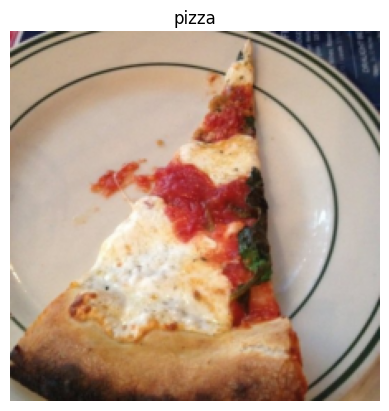

In [4]:
#GitHub MrDbourke içeriğini indiriyoruz.
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
#Train ve Test veri yollarını oluşturuyoruz.
train_dir = image_path / "train"
test_dir = image_path / "test"

#ViT için yükseklik ve genişliği 224x224=4096 haline getirmeliyiz.
IMG_SIZE = 224

# Elle Transform'u oluşturalım.
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Transforma boyutu 224'ten oluşturuldu: {manual_transforms}")

# Batch Miktarı
BATCH_SIZE = 32 #Normalde 4096 olmalı ama yüksek bir sistemimiz yok. Dolayısıyla 32'de kalacağız.

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Yukarıda oluşturduğumuz transform ile devam edeiyoruz.
    batch_size=BATCH_SIZE
)

# GÖRSELLEŞTİRME YAPALIM
# Resimlerin batch'te olanlarını alalım.
image_batch, label_batch = next(iter(train_dataloader))

# Batch'ten bir resim alalım.
image, label = image_batch[0], label_batch[0]

# Görselleştirelim.
plt.imshow(image.permute(1, 2, 0)) #  [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

##Aşama-3: Verileri Bölme Sınıf, Konum ve Patch Ayarlama

In [5]:
# Örnek bir Veri Oluşturalım.
height = 224 # H
width = 224 # W
color_channels = 3 # C -> Renk kanalları
patch_size = 16 # P

# Patch sayısını oluşturma
number_of_patches = int((height * width) / patch_size**2)
print(f"Patch Sayısı (N) with Resim Yüksekliği (H={height}), Genişliği (W={width}) ve Patch Miktarı (P={patch_size}): {number_of_patches}")

Patch Sayısı (N) with Resim Yüksekliği (H=224), Genişliği (W=224) ve Patch Miktarı (P=16): 196


In [6]:
# Girdi biçimi (Input Shape) -> H, W, C
embedding_layer_input_shape = (height, width, color_channels)

# Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Girdi biçimi (Input Shape) -> H, W, C: {embedding_layer_input_shape}")
print(f"Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: {embedding_layer_output_shape}")

Girdi biçimi (Input Shape) -> H, W, C: (224, 224, 3)
Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: (196, 768)


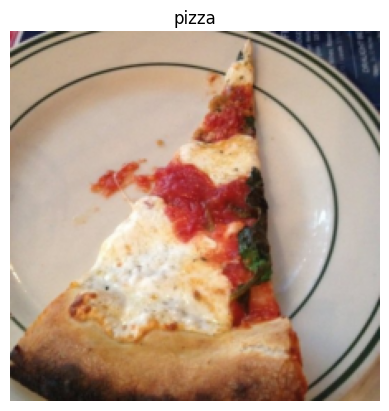

In [7]:
# Resmi Görüntüleme
plt.imshow(image.permute(1, 2, 0)) #Output Shape
plt.title(class_names[label])
plt.axis(False);

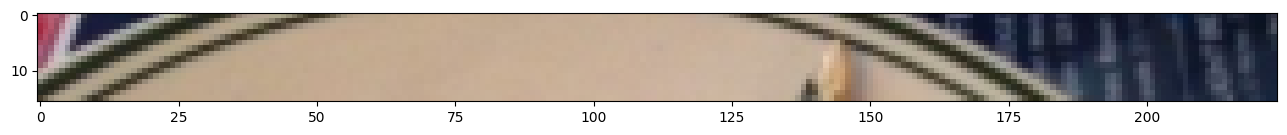

In [8]:
#(color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Patch miktarı belirtelim ve pikselleri görelim.
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Her Satırdaki patch sayısı: 14.0
Patch boyutu: 16 pixel x 16 pixel


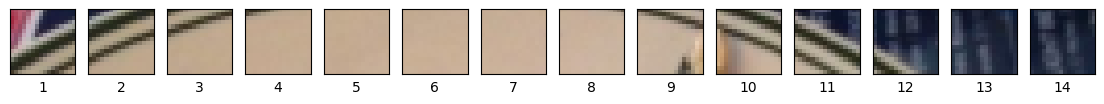

In [9]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Her Satırdaki patch sayısı: {num_patches}\nPatch boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # bir sütundaki her bir patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Resimleri etiketleri ile yan yana görüntüleyelim.
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # Yükseklik ve genişlik yan yana
    axs[i].set_xlabel(i+1) # Etiket
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Satırdaki Patch Sayısı: 14.0        
Sütundaki Patch Sayısı: 14.0        
Toplam Patch Sayısı: 196.0        
Patch Boyutu: 16 pixel x 16 pixel


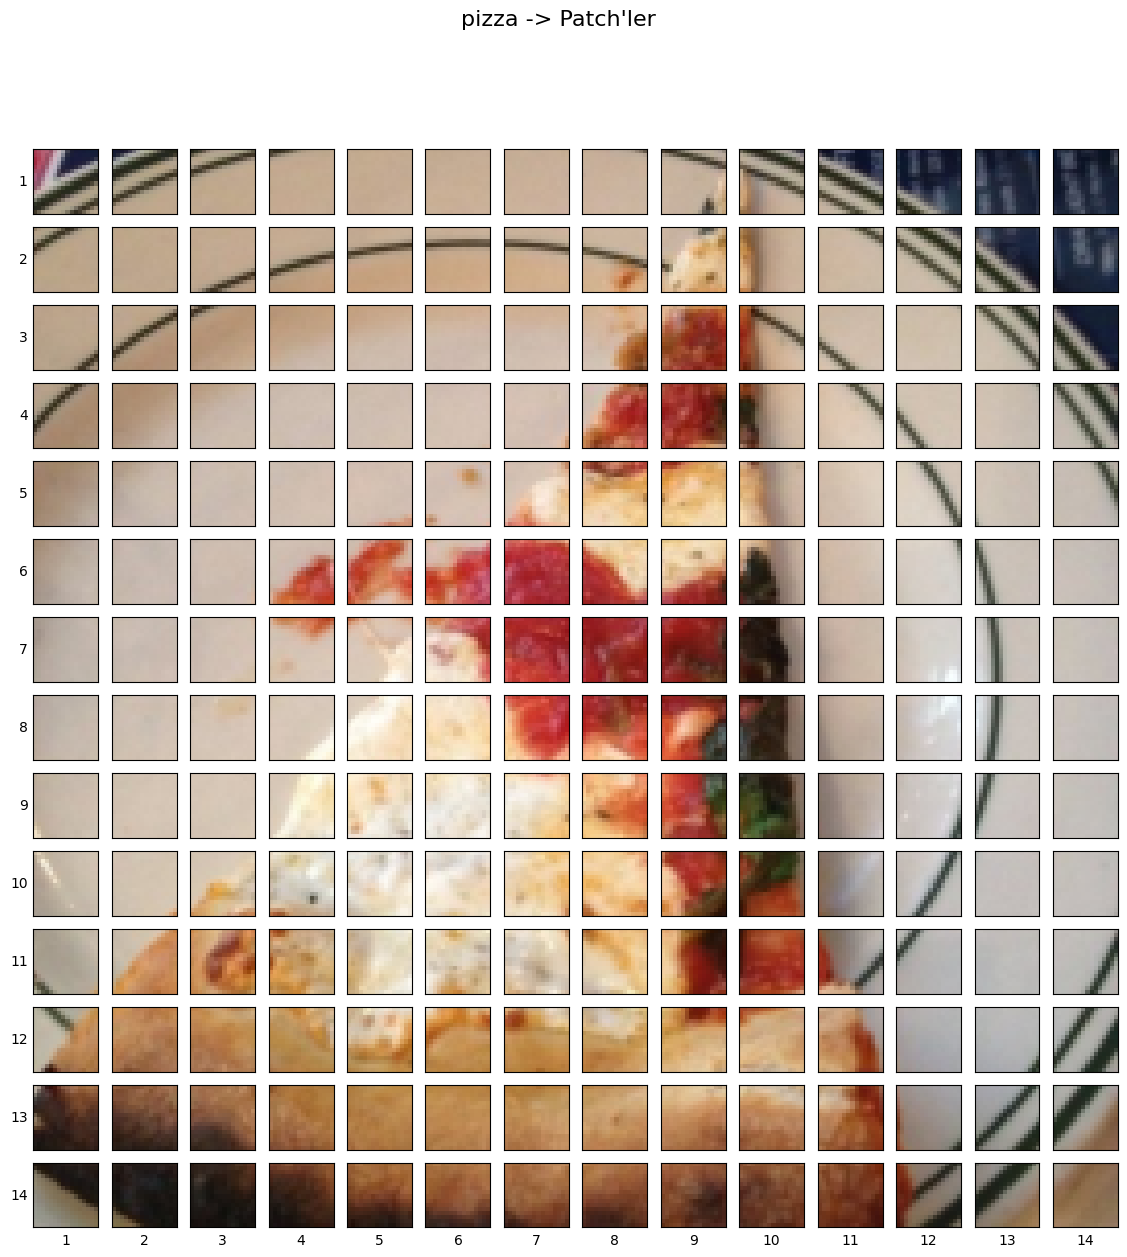

In [10]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Satırdaki Patch Sayısı: {num_patches}\
        \nSütundaki Patch Sayısı: {num_patches}\
        \nToplam Patch Sayısı: {num_patches*num_patches}\
        \nPatch Boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=img_size // patch_size, # int değerinde olmalı, float olamaz!
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Döngüler halinde her bir patch'i resmin yükseklik ve genişliğine oranla yerleştirelim.
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # image_permuted -> (Height, Width, Color Channels)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        # Etiketleri yazdırma
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Grafiğe Ana Başlık
fig.suptitle(f"{class_names[label]} -> Patch'ler", fontsize=16)
plt.show()

5 Evrimsel Boyut: [355, 724, 144, 340, 742]


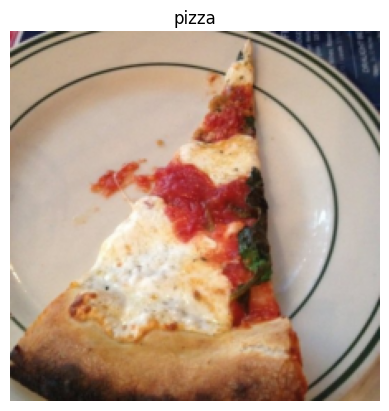

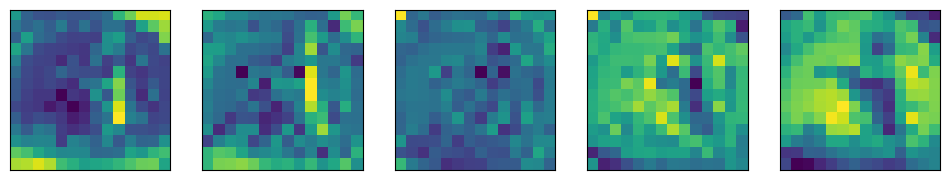

In [11]:
from torch import nn

# Patch Miktarı
patch_size=16

# Conv2d katmanı fakat ViT'nin istediği değerlerde yani channel X Patch x Patch
conv2d = nn.Conv2d(in_channels=3, # renk kanal sayısı
                   out_channels=768, # Embed size
                   kernel_size=patch_size, # patch_size, patch_size
                   stride=patch_size,
                   padding=0)

# Resmi görelim
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# convolutional layer'da boyut ekleyelim.
image_out_of_conv = conv2d(image.unsqueeze(0)) #(height, width, color_channels) -> (batch, height, width, color_channels)
# Rasgele 5 Evrimsel Boyut Ekleyelim.
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"5 Evrimsel Boyut: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
# Görselleştirelim.
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [12]:
# Tek bir öğrenme verisinin değerlerine bakalım.
single_feature_map = image_out_of_conv[:, 0, :, :]
print(single_feature_map, single_feature_map.requires_grad)

tensor([[[0.7448, 0.5884, 0.6563, 0.7844, 0.8015, 0.8168, 0.8269, 0.8479,
          0.8566, 0.7059, 0.5727, 0.3456, 0.2679, 0.2710],
         [0.7536, 0.7796, 0.6983, 0.7374, 0.7608, 0.7102, 0.7686, 0.7665,
          0.8028, 0.6917, 0.8797, 0.8864, 0.4735, 0.2238],
         [0.7335, 0.6845, 0.6912, 0.7885, 0.8413, 0.8655, 0.8762, 0.7745,
          0.4280, 0.5600, 0.7916, 0.8938, 0.8777, 0.4353],
         [0.5492, 0.7067, 0.8434, 0.8894, 0.8921, 0.9042, 0.9040, 0.7170,
          0.3389, 0.4398, 0.9740, 0.8272, 0.9116, 0.6758],
         [0.6672, 0.8269, 0.8840, 0.8960, 0.8810, 0.8639, 0.9642, 0.8197,
          0.8647, 0.7504, 0.8942, 0.8357, 0.9076, 0.9671],
         [0.7579, 0.8724, 0.8756, 0.7026, 0.4397, 0.5318, 0.3452, 0.4897,
          0.6170, 0.3223, 0.8551, 0.9781, 0.7993, 0.8993],
         [0.7978, 0.8820, 0.8882, 0.8941, 0.9719, 0.9900, 0.3409, 0.2598,
          0.1788, 0.1884, 0.8017, 0.9656, 0.8992, 0.9061],
         [0.8320, 0.8984, 0.9022, 0.9710, 1.1254, 1.0462, 0.6402, 0.5

In [13]:
# Tensörümüzün Şekli
print(f"Mevcut Tensör Şeklimiz: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Mevcut Tensör Şeklimiz: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [14]:
#Flatten Katman Oluşturma
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (boyut 2)
                     end_dim=3) # flatten feature_map_width (boyut 3)

Resmin İlk Şekli: torch.Size([3, 224, 224])
Resmin Özellik Şekli: torch.Size([1, 768, 14, 14])
Flatten Edilmiş Görselin Şekli: torch.Size([1, 768, 196])


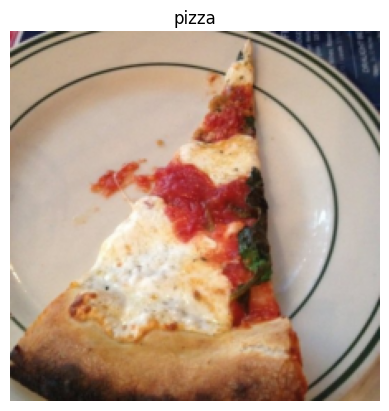

In [15]:
# 1. Single Resimi Alalım
plt.imshow(image.permute(1, 2, 0)) # matplotlib'te görünecek hale getirelim.
plt.title(class_names[label]) #Etiketleri yazdır.
plt.axis(False);
print(f"Resmin İlk Şekli: {image.shape}")

# 2. Özellikleri Haritalaştıralım
image_out_of_conv = conv2d(image.unsqueeze(0)) #batch'e bir boyut ekleyip şekil hatalarından kaçınalım.
print(f"Resmin Özellik Şekli: {image_out_of_conv.shape}")

# 3. Flatten Edilmiş Görselin Şekli
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flatten Edilmiş Görselin Şekli: {image_out_of_conv_flattened.shape}")

In [16]:
 #196, 768 değerlerinin yerini değiştireceğiz.
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Sekans boyutunun Değişimi: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Sekans boyutunun Değişimi: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


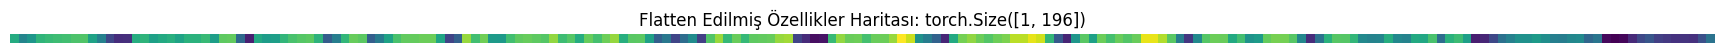

In [17]:
# flatten edilmiş özellikler haritası (Tek satır)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Yukarıdaki değişkeni görselleştirelim
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flatten Edilmiş Özellikler Haritası: {single_flattened_feature_map.shape}")
plt.axis(False);

In [18]:
# 1.Adım: nn.Module'den bir Patch için çalışacak sınıf oluşturalım.
class PatchEmbedding(nn.Module):
    """2D bir resmi tek boyutlu bir metin vektörüne çevireceğiz.

    Args:
        in_channels (int): Renk kanallarıdır. Minimum, başlangıç değerini 3 alacağız.
        patch_size (int): Patch miktarını input'a çevirecek. başlangıç değerini 16 alacağız.
        embedding_dim (int): Embed edilecek boyutlar. başlangıç değerini 768 alacağız.
    """
    # 2.Adım: Modülde çalışacak değişkenlerimizi tanımlayalım.
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3.Adım: conv2d ile resmi patch'lere bölelim.
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4.Adım: Flatten ederek resmi tek bir boyuta düzleştirmek için bir katman oluşturalım.
        self.flatten = nn.Flatten(start_dim=2, # Tek bir vektöre dönüşecek.
                                  end_dim=3)

    # 5.Adım: Forward metodu, klasik.
    def forward(self, x):
        # Resim kalitesinden ödün vermemek için şekli düzenleyelim.
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Resim patch miktarına bölünecek. Resmin Şekli: {image_resolution}, Patch Miktarı: {patch_size}"

        # Forward Edelim.
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6.Adım: Resmin çıktı şeklini kontrol edelim.
        return x_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

#ÇALIŞTIRALIM...
# Patch embed katmanlı değişken tasarlayalım.
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Bir resmi çalıştıralım.
print(f"Input Shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Hata çıkmaması için katman ekledik.
print(f"Output patch embed shape: {patch_embedded_image.shape}")

Input Shape: torch.Size([1, 3, 224, 224])
Output patch embed shape: torch.Size([1, 196, 768])


In [19]:
# Rastgele girdi veri oluşturalım.
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

# Summary ile, Patch Embedding'in katmanlarına bakalım.
summary(PatchEmbedding(),
         input_size=random_input_image,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [20]:
# Batch miktarı ve embedding boyutunu alalım
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Embedding'ler için her bir boyuta bir token oluşturalım.
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # embed edileni öğretilebilir hale getiriyoruz.

# class_token değişkeninin ilk 10 birimini yazdıraım.
print(class_token[:, :, :10])
print(f"class_token Biçimi: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class_token Biçimi: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [21]:
# Sınıfı belirleyen class_token'i patch'in önüne alacağız.
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # dim =1

# Yazdıralım.
print(patch_embedded_image_with_class_embedding)
print(f"Patch sekansında sınıf belirteci önde: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4783, -0.3553,  0.3382,  ..., -0.1582, -0.1492,  0.1750],
         [-0.4359, -0.3498,  0.2441,  ..., -0.2015, -0.1724, -0.0729],
         ...,
         [-0.3824, -0.2024,  0.2532,  ..., -0.1064, -0.0953,  0.1009],
         [-0.4942, -0.2967,  0.2271,  ..., -0.0531, -0.2143,  0.2132],
         [-0.5317, -0.3174,  0.2517,  ..., -0.1419, -0.1523,  0.1524]]],
       grad_fn=<CatBackward0>)
Patch sekansında sınıf belirteci önde: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [23]:
# N Hesaplama (patch miktarı sayısı)
number_of_patches = int((height * width) / patch_size**2)

# embedding boyutu ekleme
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Öğrenilebilir 1D embedding pozisyonu oluşturma
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # grad öğrenilebilir olduğunu bize söylüyor.

# İlk 10 verinin 1D pozisyonuna bakalım
print(position_embedding[:, :10, :10])
print(f"Position embedding Şekli: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

# Position Enbedding'i patch'e class_token ile birlikte ekleme
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embedding'ler, class token + positional embeddings: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding Şekli: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]
tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5217, 0.6447, 1.3382,  ..., 0.8418, 0.8508, 1.1750],
         [0.5641, 0.6502, 1.2441,  ..., 0.7985, 0.8276, 0.9271],
         ...,
         [0.6176, 0.7976, 1.2532,  ..., 0.8936, 0.9047, 1.1009],
         [0.5058, 0.7033, 1.2271,  ..., 0.9469, 0.7857, 1.2132],
         [0.468

In [24]:
set_seeds()

# 1. Patch Miktarını Ayarla
patch_size = 16

# 2. Orjinal resmin tensör boyutunu yazdıralım
print(f"Resim tensör Shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. resim tensöre ekstra bir batch boyutu ekle
x = image.unsqueeze(0)
print(f"Ekstra batch boyutu eklenmiş, Resim Tensörü: {x.shape}")

# 4. Patch Embedding Katmanı Ekleme
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Resmi Embedding Katmanından Geçirme
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Class Token'i Embedding'e Ekleme
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # Öğrenilebilir yaptık.
print(f"Class Token Embedding Shape: {class_token.shape}")

# 7. Patch'i ClassToken'li hale getirdik.
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch Embedding + Class Token Shape: {patch_embedding_class_token.shape}")

# 8. Position Embedding'le bir araya getirdik.
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # Öğrenilebilir yaptık.

# 9. Position Embedding + Class Token + Patch Embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding

Resim tensör Shape: torch.Size([3, 224, 224])
Ekstra batch boyutu eklenmiş, Resim Tensörü: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class Token Embedding Shape: torch.Size([1, 1, 768])
Patch Embedding + Class Token Shape: torch.Size([1, 197, 768])


##MSA -> Multi-Head Attention

In [25]:
# 1. nn.Module ile MSA
class MultiheadSelfAttentionBlock(nn.Module):

    # 2. Başlatılırken lazım olacak alt parametreleri tanıtalım.
    def __init__(self,
                 embedding_dim:int=768, # Gizli katman
                 num_heads:int=12, # Başlık sayısı
                 attn_dropout:float=0): # Düşecek nesnes sayısı
        super().__init__()

        # 3. LN Tasarlama
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. MSA Katmanı Oluşturma
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) #batch boyutu ilk gelsin

    # 5. forward() ederek devam etma
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query
                                             key=x, # key
                                             value=x, # value
                                             need_weights=False) #weight çıktı da olmalı mı?
        return attn_output

In [26]:
# MSABlock Oluşturma
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

# MSA'yı Yazdırma
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"MSA block Girdi Şekli: {patch_and_position_embedding.shape}")
print(f"MSA block Çıktı Şekli: {patched_image_through_msa_block.shape}")

MSA block Girdi Şekli: torch.Size([1, 197, 768])
MSA block Çıktı Şekli: torch.Size([1, 197, 768])


## MLP -> Multilayer Perceptron

In [27]:
# 1. nn.Module ile MLPBlock
class MLPBlock(nn.Module):

    # 2. Girilecek parametreleri oluştur.
    def __init__(self,
                 embedding_dim:int=768, # Gizli Katman
                 mlp_size:int=3072, # MLP miktarı
                 dropout:float=0.1): # Dropout miktarı
        super().__init__()

        # 3. LN KAtmanı Oluşturma
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. MLP Katmanları Oluşturma
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # non-linear katman
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout) #Dropout ayarlama
        )

    # 5. forward()
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [28]:
# MLPBlock Nesnesi
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072, dropout=0.1)

# Yazdıralım.
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"MLP Girdi Şekli: {patched_image_through_msa_block.shape}")
print(f"MLP Çıktı Şekli: {patched_image_through_mlp_block.shape}")

MLP Girdi Şekli: torch.Size([1, 197, 768])
MLP Çıktı Şekli: torch.Size([1, 197, 768])
